In [1]:
import numpy as np
import tensorflow as tf

C:\Users\u69205\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# The matrix is Glove Embedding Matrix

In [3]:
wordslist = np.load('wordsList.npy')
print(type(wordslist))
print('Loaded the word list!')
wordslist = wordslist.tolist() #Originally loaded as numpy array
wordslist = [word.decode('UTF-8') for word in wordslist] #Encode words as UTF-8
wordvectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

<class 'numpy.ndarray'>
Loaded the word list!
Loaded the word vectors!


# calculate number of words in review files

In [4]:
from os import listdir
from os.path import isfile, join
positiveFiles = ['positiveReviews/' + f for f in listdir('positiveReviews/') if isfile(join('positiveReviews/', f))]
negativeFiles = ['negativeReviews/' + f for f in listdir('negativeReviews/') if isfile(join('negativeReviews/', f))]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding = 'utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

Positive files finished
Negative files finished
The total number of files is 25000
The total number of words in the files is 5844680
The average number of words in the files is 233.7872


# create histogram

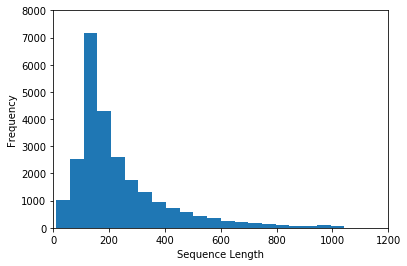

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

In [6]:
maxSeqLength = 250

# Data Pre-processing

In [7]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

# create id matrix

In [8]:
# to create idsMatrix
# Or alternatively, you can load the pre-computed IDs matrix, as given below
# ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
# fileCounter = 0
# for pf in positiveFiles:
#    with open(pf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 

# for nf in negativeFiles:
#    with open(nf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 
# #Pass into embedding function and see if it evaluates. 

# np.save('idsMatrix', ids)

In [9]:
# loading pre-computed IDs matrix

In [10]:
ids = np.load('idsMatrix.npy')

# Helper function to get batches for training and test data

In [11]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,11499)
            labels.append([1,0])
        else:
            num = randint(13499,24999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

# Tensorflow Construction Phase

In [12]:
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 60000
numDimensions = 300

# tensorflow placeholders

In [13]:
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordvectors,input_data)
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [14]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)

prediction = (tf.matmul(last, weight) + bias)
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

# The following code is optional, apply for tensorboard.  This is not working!! something that I need to fix

In [15]:
#import datetime
#tf.summary.scalar('Loss', loss)
#tf.summary.scalar('Accuracy', accuracy)
#merged = tf.summary.merge_all()
#logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
#writer = tf.summary.FileWriter(logdir, sess.graph)

# Model Training - Execution Phase

In [16]:
#sess.close()
sess = tf.InteractiveSession()
saver = tf.train.Saver()

In [17]:
# very expensive computation.  

#saver = tf.train.Saver()
#sess.run(tf.global_variables_initializer())

#for i in range(iterations):
    #print(i)
    #nextBatch, nextBatchLabels = getTrainBatch();
    #sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
    
    #if ((i+1) % 2000 == 0 and i != 0):
        #print(i)
        #save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
        #print("saved to %s" % save_path)

In [18]:
saver.restore(sess, tf.train.latest_checkpoint('models'))

INFO:tensorflow:Restoring parameters from models\pretrained_lstm.ckpt-59999


In [19]:
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: 
                                                           nextBatchLabels})) * 100)

Accuracy for this batch: 91.66666865348816
Accuracy for this batch: 79.16666865348816
Accuracy for this batch: 83.33333134651184
Accuracy for this batch: 75.0
Accuracy for this batch: 91.66666865348816
Accuracy for this batch: 91.66666865348816
Accuracy for this batch: 75.0
Accuracy for this batch: 91.66666865348816
Accuracy for this batch: 79.16666865348816
Accuracy for this batch: 87.5
